In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import numpy.random as rnd
import os
plt.rcParams['axes.edgecolor'] = 'w'
import sklearn

In [3]:
sklearn.__version__

'0.21.3'

In [5]:
def despine(axs):
    if type(axs) != type([]):
        axs = [axs]
    for ax in axs:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['left'].set_position(('outward', 10))

In [6]:
co2_gr = pd.read_csv('data/co2_gr_gl.txt',
                    delim_whitespace=True,
                    skiprows=62,
                    names=['year', 'rate', 'err'])

Text(0.5,1,'CO$_2$ growth rate')

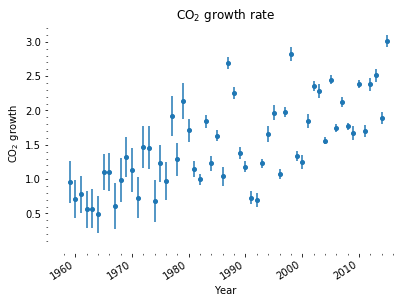

In [9]:
fig, ax = plt.subplots(1,1)
ax.errorbar(co2_gr['year'], co2_gr['rate'],
           yerr=co2_gr['err'],
           ls='None',
           elinewidth=1.5,
           capthick=1.5,
           marker='.',
           ms=8)
despine(ax)
plt.minorticks_on()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=33, ha='right')
ax.set_ylabel('CO$_2$ growth')
ax.set_xlabel('Year')
ax.set_xlim((1957, 2016))
ax.set_title('CO$_2$ growth rate')

In [13]:
from sklearn.linear_model import LinearRegression, Lasso
#from sklearn import cross_validation
#cross_validation is deprecated since version 0.18. This module will be removed in 0.20. Use sklearn.model_selection.train_test_split instead
from sklearn.model_selection import train_test_split 

In [14]:
x_test, x_train, y_test, y_train = train_test_split(
co2_gr['year'], co2_gr['rate'],test_size=0.75, random_state=0)
X_train = x_train[:, np.newaxis]
X_test = x_test[:, np.newaxis]
line_x = np.array([1955, 2025])

In [15]:
est_lin = LinearRegression()
est_lin.fit(X_train, y_train)
lin_pred = est_lin.predict(line_x.reshape(-1, 1))

In [16]:
est_lasso = Lasso(alpha=0.7)
est_lasso.fit(X_train, y_train)
lasso_pred = est_lasso.predict(line_x.reshape(2,1))

In [17]:
def printstuff(estimator, A, b):
    name = estimator.__str__().split('(')[0]
    print('+'*6, name, '+'*6)
    print('Slope: {0:.3f} Intercept:{1:.2f}'.format(
    estimator.coef_[0], estimator.intercept_))
    print("Mean squared residuals: {0:.2f}".format(
    np.mean((estimator.predict(A) -b)**2)))
    print('Variance score: {0:.2f}'.format(estimator.score(A,b)))

In [18]:
printstuff(est_lin, X_test, y_test)
printstuff(est_lasso, X_test, y_test)

++++++ LinearRegression ++++++
Slope: 0.027 Intercept:-51.60
Mean squared residuals: 0.17
Variance score: 0.56
++++++ Lasso ++++++
Slope: 0.024 Intercept:-46.16
Mean squared residuals: 0.17
Variance score: 0.56


Text(0.5,1,'CO$_2$ growth rate')

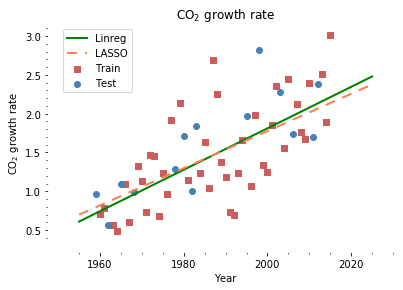

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, marker='s',
          label='Train', color='IndianRed')
ax.scatter(X_test, y_test, label='Test', color='SteelBlue')
ax.plot(line_x, lin_pred, color='Green', label='Linreg', lw=2)
ax.plot(line_x, lasso_pred, color='Coral',
       dashes=(5,4), label='LASSO', lw=2)
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.legend(loc=2, fontsize=10, numpoints=1)
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=7)
ax.set_xlim(1950, 2030)
ax.set_title('CO$_2$ growth rate')

In [22]:
from sklearn.metrics import r2_score
r2_lin = r2_score(co2_gr['rate'], est_lin.predict(
co2_gr['year'].values.reshape(-1,1)))
r2_lasso = r2_score(co2_gr['rate'], est_lasso.predict(
co2_gr['year'].values.reshape(-1,1)))
print('LinearSVC: {0:.2f}\nLASSO:\t {1:.2f}')

LinearSVC: {0:.2f}
LASSO:	 {1:.2f}


In [29]:
import pymc
x = co2_gr['year'].values
y = co2_gr['rate'].values
y_error = co2_gr['err'].values
def model(x, y):
    slope = pymc.Normal('slope', 0.1, 1.)
    intercept = pymc.Normal('intercept', -50., 10.)
    @pymc.deterministic(plot=False)
    def linear(x=x, slope=slope, intercept=intercept):
        return x*slope + intercept
    f = pymc.Normal('f', mu=linear, tau=1.0/y_error, value=y, observed=True)
    return locals()
MDL = pymc.MCMC(model(x,y))
MDL.sample(5e5, 5e4, 100)
y_fit = MDL.stats()['linear']['mean']
slope = MDL.stats()['slope']['mean']
intercept = MDL.stats()['intercept']['mean']

 [-----------------100%-----------------] 500000 of 500000 complete in 23.9 sec

In [30]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ols_results = smf.ols('rate~year', co2_gr).fit()
ols_params = np.flipud(ols_results.params)

In [31]:
print('    Slope Intercept \nML : \
{0:.3f} {1:.3f} \nOLS: {2:.3f} \
{3:.3f} \nBay: {4:.3f} \
{5:.3f}'.format(est_lin.coef_[0],
               est_lin.intercept_,
               ols_params[0],
               ols_params[1],
               slope,
               intercept))

    Slope Intercept 
ML : 0.027 -51.597 
OLS: 0.027 -51.812 
Bay: 0.026 -50.005


Text(0.5,1,'CO$_2$ growth rate')

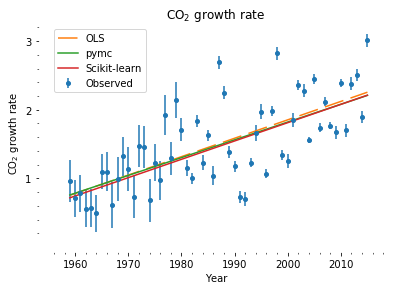

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=y_error, ls='None',
           elinewidth=1.5, capthick=1.5,
           marker='.', ms=8, label='Observed')
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.plot([x.min(), x.max()],
       [ols_results.fittedvalues.min(),
       ols_results.fittedvalues.max()],
       lw=1.5, label='OLS',
       dashes=(13,5))
ax.plot(x, y_fit, lw=1.5, label='pymc')
ax.plot([x.min(), x.max()],
       est_lin.predict([[x.min(), ], [x.max(), ]]),
       label='Scikit-learn', lw=1.5)
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=7)
ax.locator_params(axis='y', nbins=4)
ax.set_xlim(1955, 2018)
ax.legend(loc=2, numpoints=1)
ax.set_title('CO$_2$ growth rate')

In [34]:
TABLE_FILE = 'data/data_ch5_clustering.pick'
mycat = pd.read_pickle(TABLE_FILE)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_ch5_clustering.pick'